# Experimentos para el preprocesamiento de los datos y arquitectura del modelo.
En este cuaderno se van a realizara un exploracion del dataset de las anotsaciones de esqueletos 2d y también se experimentara con distintas arquitecturas. 

In [3]:
# Create a DataFrame summary and a PyTorch Dataset for UCF101 2D skeletons
# This cell loads the pickle, creates a short DataFrame for easier inspection,
# and defines UCFSkeletonDataset which returns a chosen person's keypoints as a tensor.
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

# Load the pickle file
ucfdataset = 'Dataset/2d-skels/ucf101_2d.pkl'
with open(ucfdataset, 'rb') as f:
    ucf_data = pickle.load(f)

annotations = ucf_data.get('annotations', [])

# Build a compact DataFrame that summarizes each annotation for quick inspection
rows = []
for ann in annotations:
    kp = ann.get('keypoint')
    kp_shape = None
    try:
        if kp is not None:
            kp_shape = np.array(kp).shape
    except Exception:
        kp_shape = None
    rows.append({
        'frame_dir': ann.get('frame_dir'),
        'total_frames': ann.get('total_frames'),
        'img_shape': ann.get('img_shape'),
        'original_shape': ann.get('original_shape'),
        'label': int(ann.get('label')) if ann.get('label') is not None else None,
        'keypoint_shape': kp_shape,
        'has_keypoint_score': ('keypoint_score' in ann) and (ann.get('keypoint_score') is not None)
    })

df_ann = pd.DataFrame(rows)
# Save a CSV summary for quick external inspection
csv_path = 'annotations_summary.csv'
df_ann.to_csv(csv_path, index=False)
print(f"Saved annotations summary to {csv_path}")

# --- Transforms (pipeline) ---
class Compose:
    def __init__(self, transforms):
        self.transforms = list(transforms)
    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

class NormalizeKeypoints:
    """Normalize keypoints to unit coordinates using image shape.

    Expects sample to contain 'keypoint' (torch.Tensor (T,V,C)) and either
    'img_shape' or 'original_shape' (height, width) in the annotation metadata.
    """
    def __init__(self, shape_key='img_shape'):
        self.shape_key = shape_key

    def __call__(self, sample):
        kp = sample['keypoint']
        shape = sample.get(self.shape_key) or sample.get('original_shape')
        if shape is None:
            return sample
        try:
            h, w = float(shape[0]), float(shape[1])
            if w > 0 and h > 0:
                kp = kp.clone()
                # assume kp[...,0]=x, kp[...,1]=y
                kp[..., 0] = kp[..., 0] / w
                kp[..., 1] = kp[..., 1] / h
                sample['keypoint'] = kp
        except Exception:
            pass
        return sample

# Define a Dataset wrapper (no inline normalization — accepts transform)
class UCFSkeletonDataset(Dataset):
    """Dataset wrapping the annotations list from ucf101_2d.pkl.
    For samples with multiple persons (M>1) and keypoint_score available,
    it selects the person with highest mean keypoint_score. Otherwise selects person 0.

    The dataset accepts an optional `transform` callable which receives and returns
    the sample dict. This keeps normalization/augmentation separate from I/O.
    """
    def __init__(self, annotations_list, transform=None, select_best_by_score=True, dtype=torch.float32):
        self.annotations = annotations_list
        self.transform = transform
        self.select_best_by_score = select_best_by_score
        self.dtype = dtype

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = ann.get('keypoint')
        kp_score = ann.get('keypoint_score', None)

        # ensure numpy
        kp = np.array(kp)  # M x T x V x C

        if kp.ndim != 4:
            raise ValueError(f"Unexpected keypoint shape for idx={idx}: {kp.shape}")

        M = kp.shape[0]

        # choose person
        person_idx = 0
        if M > 1 and kp_score is not None and self.select_best_by_score:
            scores = np.array(kp_score)  # M x T x V
            mean_scores = scores.mean(axis=(1,2))
            person_idx = int(mean_scores.argmax())

        person_kp = kp[person_idx]  # T x V x C

        # convert to torch tensor
        tensor_kp = torch.from_numpy(person_kp.astype(np.float32))

        sample = {
            'keypoint': tensor_kp,  # (T, V, C)
            'label': int(ann.get('label')) if ann.get('label') is not None else None,
            'frame_dir': ann.get('frame_dir'),
            'total_frames': ann.get('total_frames'),
            'img_shape': ann.get('img_shape'),
            'original_shape': ann.get('original_shape')
        }

        if kp_score is not None:
            score_np = np.array(kp_score)[person_idx]  # T x V
            sample['score'] = torch.from_numpy(score_np.astype(np.float32))

        # apply transform if provided
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

# Create a Normalize transform and dataset instance (transform applied externally)
normalize = NormalizeKeypoints(shape_key='img_shape')
ucf_dataset = UCFSkeletonDataset(annotations, transform=normalize)

# Quick checks / example
print(f"Loaded {len(annotations)} annotations. df_ann shape: {df_ann.shape}")
print(df_ann.head())
if len(ucf_dataset) > 0:
    s = ucf_dataset[0]
    print('\nExample sample keys:', list(s.keys()))
    print('keypoint tensor shape (T, V, C):', s['keypoint'].shape)
    # show a couple normalized coordinate values (if img_shape exists)
    print('example coords (first frame, first joint):', s['keypoint'][0,0])
    if 'score' in s:
        print('score tensor shape (T, V):', s['score'].shape)
    print('label:', s['label'])
else:
    print('Dataset is empty.')

# -- Collate / padding helpers for DataLoader batching --

def pad_sequence_kp(kps):
    """Pad a list of keypoint tensors [(T, V, C), ...] to (B, T_max, V, C).
    Returns (padded_kps, mask) where mask is (B, T_max, V) with 1 for real frames.
    """
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded = []
    masks = []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([t, pad_tensor], dim=0)
            mask = torch.cat([torch.ones((T, V)), torch.zeros((pad_len, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)  # (B, T_max, V, C)
    batch_mask = torch.stack(masks, dim=0)  # (B, T_max, V)
    return batch_kp, batch_mask


def ucf_collate_fn(batch):
    """Collate function for UCFSkeletonDataset.
    Produces:
      - 'keypoint': (B, T, V, C)
      - 'mask': (B, T, V)
      - 'label': (B,)
      - 'frame_dir', 'total_frames'
      - 'score': (B, T, V) or None
    """
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]

    batch_kp, batch_mask = pad_sequence_kp(kps)

    batch_scores = None
    if any(s is not None for s in scores):
        # replace None with zeros of matching shape before padding
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        # pad scores to (B, T_max, V)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([s, pad], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)

    return {
        'keypoint': batch_kp,
        'mask': batch_mask,
        'label': labels,
        'frame_dir': frame_dirs,
        'total_frames': total_frames,
        'score': batch_scores
    }

# Example usage with DataLoader
from torch.utils.data import DataLoader
loader = DataLoader(ucf_dataset, batch_size=4, shuffle=False, collate_fn=ucf_collate_fn)
for batch in loader:
    print('Batch keypoint shape:', batch['keypoint'].shape)  # (B, T, V, C)
    print('Batch mask shape:', batch['mask'].shape)          # (B, T, V)
    print('Labels shape:', batch['label'].shape)
    if batch['score'] is not None:
        print('Score shape:', batch['score'].shape)
    break


Saved annotations summary to annotations_summary.csv
Loaded 13320 annotations. df_ann shape: (13320, 7)
                  frame_dir  total_frames   img_shape original_shape  label  \
0  v_ApplyEyeMakeup_g08_c01           119  (256, 340)     (256, 340)      0   
1  v_ApplyEyeMakeup_g08_c02           116  (256, 340)     (256, 340)      0   
2  v_ApplyEyeMakeup_g08_c03           145  (256, 340)     (256, 340)      0   
3  v_ApplyEyeMakeup_g08_c04           223  (256, 340)     (256, 340)      0   
4  v_ApplyEyeMakeup_g08_c05           275  (256, 340)     (256, 340)      0   

    keypoint_shape  has_keypoint_score  
0  (1, 119, 17, 2)                True  
1  (1, 116, 17, 2)                True  
2  (1, 145, 17, 2)                True  
3  (2, 223, 17, 2)                True  
4  (1, 275, 17, 2)                True  

Example sample keys: ['keypoint', 'label', 'frame_dir', 'total_frames', 'img_shape', 'original_shape', 'score']
keypoint tensor shape (T, V, C): torch.Size([119, 17, 2])
exam

In [6]:
# Minimal training loop using the provided LSTM baseline
# Integrates Models/lstm_model.py, creates train/val splits, and runs 1 epoch.
import sys
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ensure project root is importable
proj_root = Path('.').resolve()
if str(proj_root) not in sys.path:
    sys.path.append(str(proj_root))

# import the LSTM model
from Models.lstm_model import SkeletonLSTM

# Build a simple train/val split (try stratified split with sklearn if available)
labels = df_ann['label'].values
indices = df_ann.index.values

try:
    from sklearn.model_selection import train_test_split
    train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
except Exception:
    # fallback: random split
    rng = np.random.RandomState(42)
    perm = rng.permutation(len(indices))
    split = int(0.8 * len(indices))
    train_idx = indices[perm[:split]]
    val_idx = indices[perm[split:]]

# subset annotations using indices
train_anns = [annotations[i] for i in train_idx]
val_anns = [annotations[i] for i in val_idx]

# Right-padding collate so the LSTM's last output corresponds to the actual last frame
def pad_sequence_kp_right(kps):
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded = []
    masks = []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([pad_tensor, t], dim=0)  # left-pad
            mask = torch.cat([torch.zeros((pad_len, V)), torch.ones((T, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)
    batch_mask = torch.stack(masks, dim=0)
    return batch_kp, batch_mask

def ucf_collate_fn_right(batch):
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]

    batch_kp, batch_mask = pad_sequence_kp_right(kps)

    batch_scores = None
    if any(s is not None for s in scores):
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([pad, s], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)

    return {
        'keypoint': batch_kp,
        'mask': batch_mask,
        'label': labels,
        'frame_dir': frame_dirs,
        'total_frames': total_frames,
        'score': batch_scores
    }

# Create datasets and loaders
train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
val_ds = UCFSkeletonDataset(val_anns, transform=normalize)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=ucf_collate_fn_right)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=ucf_collate_fn_right)

# Create model
num_classes = int(df_ann['label'].nunique())
model = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Minimal training: 1 epoch to verify everything runs
n_epochs = 1
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)  # (B, T, V, C)
        labels_b = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model(kp)
            loss = criterion(logits, labels_b)
            val_loss += loss.item() * labels_b.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels_b).sum().item()
            val_total += labels_b.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Save a small checkpoint
ckpt_path = 'lstm_minimal_checkpoint.pt'
torch.save({'model_state': model.state_dict(), 'num_classes': num_classes}, ckpt_path)
print('Saved checkpoint to', ckpt_path)


Epoch 1: train_loss=4.0971, train_acc=0.0510, val_loss=3.6687, val_acc=0.0931
Saved checkpoint to lstm_minimal_checkpoint.pt


Loaded checkpoint lstm_minimal_checkpoint.pt
Using existing train_loader / val_loader
Epoch 1: train_loss=3.5751, train_acc=0.0999, val_loss=3.5384, val_acc=0.1081
Epoch 1: train_loss=3.5751, train_acc=0.0999, val_loss=3.5384, val_acc=0.1081
Epoch 2: train_loss=3.3134, train_acc=0.1417, val_loss=3.2941, val_acc=0.1520
Epoch 2: train_loss=3.3134, train_acc=0.1417, val_loss=3.2941, val_acc=0.1520
Epoch 3: train_loss=3.1069, train_acc=0.1810, val_loss=2.9588, val_acc=0.2192
Epoch 3: train_loss=3.1069, train_acc=0.1810, val_loss=2.9588, val_acc=0.2192
Epoch 4: train_loss=2.9171, train_acc=0.2195, val_loss=2.6839, val_acc=0.2688
Epoch 4: train_loss=2.9171, train_acc=0.2195, val_loss=2.6839, val_acc=0.2688
Epoch 5: train_loss=2.7109, train_acc=0.2532, val_loss=2.6225, val_acc=0.2752
Epoch 5: train_loss=2.7109, train_acc=0.2532, val_loss=2.6225, val_acc=0.2752
Epoch 6: train_loss=2.6181, train_acc=0.2778, val_loss=2.4999, val_acc=0.3101
Epoch 6: train_loss=2.6181, train_acc=0.2778, val_loss=2

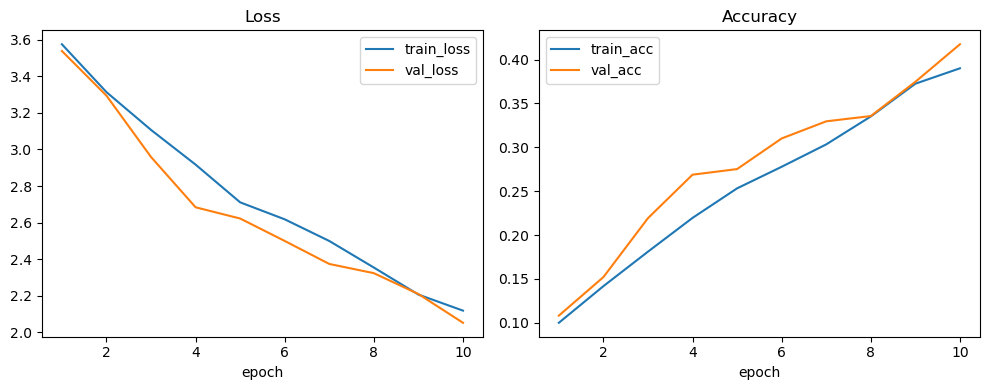

In [7]:
# Continue training (extended) from checkpoint, log metrics and plot results
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_epochs = 10
save_ckpt = 'lstm_trained.pt'
history_csv = 'training_history.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate model and load minimal checkpoint if present
from Models.lstm_model import SkeletonLSTM
num_classes = int(df_ann['label'].nunique())
model_ext = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)
if os.path.exists('lstm_minimal_checkpoint.pt'):
    ckpt = torch.load('lstm_minimal_checkpoint.pt', map_location=device)
    model_ext.load_state_dict(ckpt['model_state'])
    print('Loaded checkpoint lstm_minimal_checkpoint.pt')
else:
    print('No minimal checkpoint found; starting from scratch')

model_ext.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ext.parameters(), lr=1e-3)

# Use existing DataLoaders if present; otherwise recreate (lighter params)
try:
    train_loader
    val_loader
    print('Using existing train_loader / val_loader')
except NameError:
    print('Recreating DataLoaders (may be slower)')
    train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
    val_ds = UCFSkeletonDataset(val_anns, transform=normalize)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=ucf_collate_fn_right)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=ucf_collate_fn_right)

# Training loop
history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, n_epochs+1):
    model_ext.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model_ext(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)
    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    model_ext.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model_ext(kp)
            loss = criterion(logits, labels_b)
            val_loss += loss.item() * labels_b.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels_b).sum().item()
            val_total += labels_b.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Save checkpoint and history
torch.save({'model_state': model_ext.state_dict(), 'num_classes': num_classes}, save_ckpt)
print('Saved checkpoint to', save_ckpt)

hist_df = pd.DataFrame(history)
hist_df.to_csv(history_csv, index=False)
print('Saved training history to', history_csv)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train_loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist_df['epoch'], hist_df['train_acc'], label='train_acc')
plt.plot(hist_df['epoch'], hist_df['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()


In [8]:
# Per-class analysis: confusion matrix, per-class val accuracy, counts, and 3 x 5-class suggestions
import numpy as np
import pandas as pd
import torch
from collections import Counter, defaultdict

# Ensure we have a validation loader and a trained model in the notebook namespace
try:
    val_loader
    model_ext
except NameError:
    raise RuntimeError('val_loader or model_ext not found. Run previous cells to create them.')

device = next(model_ext.parameters()).device
model_ext.eval()
all_preds = []
all_labels = []
all_frame_dirs = []

with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model_ext(kp)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels_b.cpu().numpy())
        all_frame_dirs.extend(batch['frame_dir'])

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# confusion matrix (implement without sklearn for robustness)
num_classes = int(df_ann['label'].nunique())
conf = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(all_labels, all_preds):
    conf[t, p] += 1

# per-class counts and accuracy
class_counts = conf.sum(axis=1)
class_correct = np.diag(conf)
with np.errstate(divide='ignore', invalid='ignore'):
    class_acc = np.where(class_counts>0, class_correct / class_counts, 0.0)

# derive a human-readable name for each label from df_ann.frame_dir (most common mapping)
label_to_names = defaultdict(Counter)
for _, row in df_ann.iterrows():
    lab = int(row['label'])
    fd = row['frame_dir']
    # attempt to extract action name from frame_dir, e.g. 'v_ActionName_g08_c01' -> 'ActionName'
    try:
        action = fd.split('v_')[-1].split('_g')[0]
    except Exception:
        action = fd
    label_to_names[lab][action] += 1

label_to_name = {lab: label_to_names[lab].most_common(1)[0][0] if len(label_to_names[lab])>0 else str(lab) for lab in range(num_classes)}

# Build a summary dataframe for all labels
rows = []
for lab in range(num_classes):
    rows.append({
        'label': lab,
        'name': label_to_name.get(lab, str(lab)),
        'val_count': int(class_counts[lab]),
        'val_correct': int(class_correct[lab]),
        'val_acc': float(class_acc[lab]),
        'total_count': int((df_ann['label'] == lab).sum())
    })
summary_df = pd.DataFrame(rows).sort_values(by='val_acc', ascending=False)

print('Per-class validation summary (top 20 shown):')
print(summary_df.head(20).to_string(index=False))

# Propose 3 sets of 5 classes
# 1) Best 5 by val_acc (require at least some val samples)
best5 = summary_df[summary_df['val_count']>5].nlargest(5, 'val_acc')
# 2) Top 5 by total_count
top5_freq = summary_df.nlargest(5, 'total_count')
# 3) Mixed: 2 best, 2 medium, 1 hard (lowest acc but >=5 samples)
medium = summary_df.iloc[len(summary_df)//3: len(summary_df)//3 + 20]
mixed = pd.concat([
    summary_df[summary_df['val_count']>5].nlargest(2, 'val_acc'),
    medium.sample(2, random_state=42) if len(medium)>=2 else summary_df.sample(2, random_state=42),
    summary_df[summary_df['val_count']>5].nsmallest(1, 'val_acc')
]).drop_duplicates().head(5)

print('\nSuggested 5-class sets:')
print('\nBest 5 by val_acc:')
print(best5[['label','name','val_acc','val_count','total_count']].to_string(index=False))
print('\nTop 5 by overall frequency:')
print(top5_freq[['label','name','val_acc','val_count','total_count']].to_string(index=False))
print('\nMixed 5 (2 easy / 2 medium / 1 hard):')
print(mixed[['label','name','val_acc','val_count','total_count']].to_string(index=False))

# Save summary to CSV for inspection
summary_df.to_csv('per_class_val_summary.csv', index=False)
print('\nSaved per-class summary to per_class_val_summary.csv')


Per-class validation summary (top 20 shown):
 label             name  val_count  val_correct  val_acc  total_count
    36 HandStandPushups         26           24 0.923077          128
    46      JumpingJack         25           23 0.920000          123
    47         JumpRope         29           26 0.896552          144
    62    PlayingGuitar         32           28 0.875000          160
    69          PullUps         20           17 0.850000          100
    60      PlayingDhol         33           28 0.848485          164
    58     PlayingCello         33           28 0.848485          164
    49         Knitting         25           21 0.840000          123
    64     PlayingSitar         31           26 0.838710          157
     1    ApplyLipstick         23           19 0.826087          114
    11        Billiards         30           24 0.800000          150
    45    JugglingBalls         24           18 0.750000          121
    84    SoccerPenalty         27           

In [9]:
# Análisis por clase en el set de validación — conteos y rendimiento
# Calcula conteos por clase, matriz de confusión, per-class accuracy/precision/recall
# y sugiere 3 conjuntos de 5 clases: por frecuencia y por rendimiento.
import numpy as np
import torch
import pandas as pd

# Build val predictions using the current trained model and val_loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_eval = model_ext if 'model_ext' in globals() else (model if 'model' in globals() else None)
if model_eval is None:
    print('No model variable found in notebook scope.')
else:
    model_eval.to(device)
    model_eval.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model_eval(kp)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels_b.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # class counts in full df and in val set
    class_counts = df_ann['label'].value_counts().sort_index()
    val_counts = pd.Series(all_labels).value_counts().sort_index()

    # per-class accuracy on val
    classes = np.unique(np.concatenate([all_labels, all_preds]))
    per_class_acc = {}
    for c in classes:
        mask = (all_labels == c)
        if mask.sum() == 0:
            per_class_acc[c] = np.nan
        else:
            per_class_acc[c] = (all_preds[mask] == all_labels[mask]).sum() / mask.sum()

    # confusion matrix and precision/recall if sklearn available
    try:
        from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
        cm = confusion_matrix(all_labels, all_preds, labels=classes)
        prf = precision_recall_fscore_support(all_labels, all_preds, labels=classes, zero_division=0)
    except Exception:
        # fallback: compute simple confusion via bincount
        maxc = int(max(classes))
        cm = np.zeros((maxc+1, maxc+1), dtype=int)
        for t, p in zip(all_labels, all_preds):
            cm[int(t), int(p)] += 1
        prf = (None, None, None, None)

    # present summary dataframe
    summary_rows = []
    for c in sorted(classes):
        summary_rows.append({
            'class': int(c),
            'total_count': int(class_counts.get(c, 0)),
            'val_count': int(val_counts.get(c, 0)),
            'val_accuracy': float(per_class_acc.get(c, np.nan))
        })
    summary_df = pd.DataFrame(summary_rows).sort_values(['val_count', 'total_count'], ascending=False)

    display(summary_df.head(30))

    # Suggestions for selecting 5 classes
    # 1) top-5 by total_count
    top5_by_count = list(class_counts.sort_values(ascending=False).head(5).index.astype(int))
    # 2) top-5 by val_accuracy (only classes with at least 20 val samples)
    acc_df = summary_df.copy()
    acc_df = acc_df[acc_df['val_count'] >= 20]
    top5_by_acc = list(acc_df.sort_values('val_accuracy', ascending=False).head(5)['class'].astype(int))
    # 3) 5 relatively balanced classes: choose 5 with val_count near median
    median_count = int(summary_df['val_count'].median())
    summary_df['abs_diff_median'] = (summary_df['val_count'] - median_count).abs()
    balanced5 = list(summary_df.sort_values('abs_diff_median').head(10).sort_values('val_accuracy', ascending=False).head(5)['class'].astype(int))

    print('\nSuggested 5-class sets:')
    print('Top-5 by dataset frequency:', top5_by_count)
    print('Top-5 by validation accuracy (val_count>=20):', top5_by_acc)
    print('5 balanced candidates (near median val_count, then by val acc):', balanced5)

    # Save suggestions
    with open('class_selection_suggestions.txt', 'w') as f:
        f.write('Top-5 by dataset frequency: ' + str(top5_by_count) + '\n')
        f.write('Top-5 by validation accuracy (val_count>=20): ' + str(top5_by_acc) + '\n')
        f.write('5 balanced candidates: ' + str(balanced5) + '\n')
    print('\nSaved suggestions to class_selection_suggestions.txt')


,class,total_count,val_count,val_accuracy
23,23,167,33,0.696970
91,91,166,33,0.303030
41,41,164,33,0.575758
58,58,164,33,0.848485
60,60,164,33,0.848485
16,16,163,33,0.060606
26,26,161,32,0.437500
77,77,161,32,0.250000
9,9,160,32,0.562500
62,62,160,32,0.875000



Suggested 5-class sets:
Top-5 by dataset frequency: [23, 91, 60, 41, 58]
Top-5 by validation accuracy (val_count>=20): [36, 46, 47, 62, 69]
5 balanced candidates (near median val_count, then by val acc): [36, 98, 100, 8, 19]

Saved suggestions to class_selection_suggestions.txt


Annotations: 13320 entries; df_ann shape: (13320, 7)
Saved per-class metrics to per_class_metrics.csv
Saved per-class metrics to per_class_metrics.csv


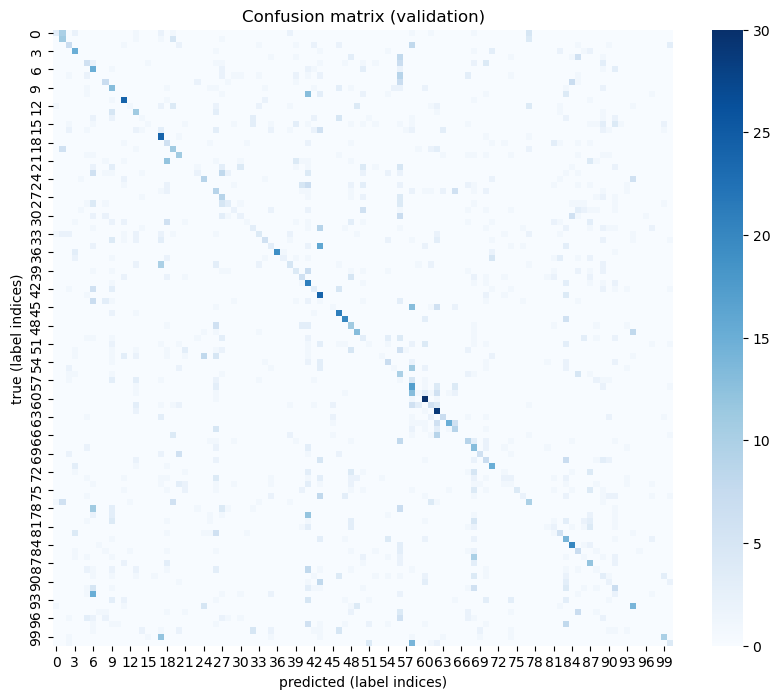


Selected 10 candidate classes saved to selected_10_classes.csv
   label  precision  recall   f1  support
0      7        0.0     0.0  0.0       27
1     21        0.0     0.0  0.0       28
2     16        0.0     0.0  0.0       33
3     10        0.0     0.0  0.0       27
4     25        0.0     0.0  0.0       30
5     22        0.0     0.0  0.0       28
6     78        0.0     0.0  0.0       29
7     80        0.0     0.0  0.0       27
8     98        0.0     0.0  0.0       26
9     92        0.0     0.0  0.0       26

Guidance: chosen classes are low-F1 but with reasonable support; try dropout, weight-decay, augmentations, temporal cropping, or class-balanced sampling.


In [5]:
# Robust evaluation: recreate missing objects if kernel restarted, then compute per-class metrics
import os
import numpy as np
import torch
from pathlib import Path
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PKL = 'Dataset/2d-skels/ucf101_2d.pkl'

# 1) Ensure annotations and df_ann are available
if 'annotations' not in globals():
    if Path('annotations_summary.csv').exists():
        df_ann = pd.read_csv('annotations_summary.csv')
        # we still need annotations list to build Dataset; try to load pickle
        if Path(DATASET_PKL).exists():
            import pickle
            with open(DATASET_PKL, 'rb') as f:
                ucf = pickle.load(f)
            annotations = ucf.get('annotations', [])
        else:
            raise RuntimeError('Neither `annotations` nor dataset pickle available in workspace.')
else:
    # annotations in globals
    annotations = globals()['annotations']
    if 'df_ann' not in globals():
        # try to build df_ann quickly
        rows = []
        for ann in annotations:
            kp = ann.get('keypoint')
            kp_shape = None
            try:
                if kp is not None:
                    kp_shape = np.array(kp).shape
            except Exception:
                kp_shape = None
            rows.append({
                'frame_dir': ann.get('frame_dir'),
                'total_frames': ann.get('total_frames'),
                'img_shape': ann.get('img_shape'),
                'original_shape': ann.get('original_shape'),
                'label': int(ann.get('label')) if ann.get('label') is not None else None,
                'keypoint_shape': kp_shape,
                'has_keypoint_score': ('keypoint_score' in ann) and (ann.get('keypoint_score') is not None)
            })
        df_ann = pd.DataFrame(rows)

print(f"Annotations: {len(annotations)} entries; df_ann shape: {df_ann.shape}")

# 2) Define minimal Dataset/transform/collate (self-contained) if not present
import torch
from torch.utils.data import Dataset, DataLoader

class NormalizeKeypoints:
    def __init__(self, shape_key='img_shape'):
        self.shape_key = shape_key
    def __call__(self, sample):
        kp = sample['keypoint']
        shape = sample.get(self.shape_key) or sample.get('original_shape')
        if shape is None:
            return sample
        try:
            h, w = float(shape[0]), float(shape[1])
            if w > 0 and h > 0:
                kp = kp.clone()
                kp[..., 0] = kp[..., 0] / w
                kp[..., 1] = kp[..., 1] / h
                sample['keypoint'] = kp
        except Exception:
            pass
        return sample

class UCFSkeletonDataset(Dataset):
    def __init__(self, annotations_list, transform=None, select_best_by_score=True):
        self.annotations = annotations_list
        self.transform = transform
        self.select_best_by_score = select_best_by_score
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = np.array(ann.get('keypoint'))
        if kp.ndim != 4:
            raise ValueError(f"Unexpected shape: {kp.shape}")
        M = kp.shape[0]
        person_idx = 0
        kp_score = ann.get('keypoint_score', None)
        if M > 1 and kp_score is not None and self.select_best_by_score:
            scores = np.array(kp_score)
            mean_scores = scores.mean(axis=(1,2))
            person_idx = int(mean_scores.argmax())
        person_kp = kp[person_idx]
        tensor_kp = torch.from_numpy(person_kp.astype(np.float32))
        sample = {
            'keypoint': tensor_kp,
            'label': int(ann.get('label')) if ann.get('label') is not None else None,
            'frame_dir': ann.get('frame_dir'),
            'total_frames': ann.get('total_frames'),
            'img_shape': ann.get('img_shape'),
            'original_shape': ann.get('original_shape')
        }
        if kp_score is not None:
            sample['score'] = torch.from_numpy(np.array(kp_score)[person_idx].astype(np.float32))
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

# right-pad collate so last actual frame is at the end (for LSTM last-step)
def pad_sequence_kp_right(kps):
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded = []
    masks = []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([pad_tensor, t], dim=0)
            mask = torch.cat([torch.zeros((pad_len, V)), torch.ones((T, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)
    batch_mask = torch.stack(masks, dim=0)
    return batch_kp, batch_mask

def ucf_collate_fn_right(batch):
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]
    batch_kp, batch_mask = pad_sequence_kp_right(kps)
    batch_scores = None
    if any(s is not None for s in scores):
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([pad, s], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)
    return {'keypoint': batch_kp, 'mask': batch_mask, 'label': labels, 'frame_dir': frame_dirs, 'total_frames': total_frames, 'score': batch_scores}

# 3) Build val_loader if missing
if 'val_loader' not in globals():
    # create train/val split
    labels_all = df_ann['label'].values
    indices = df_ann.index.values
    try:
        from sklearn.model_selection import train_test_split
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels_all, random_state=42)
    except Exception:
        rng = np.random.RandomState(42)
        perm = rng.permutation(len(indices))
        split = int(0.8 * len(indices))
        train_idx = indices[perm[:split]]
        val_idx = indices[perm[split:]]
    val_anns = [annotations[i] for i in val_idx]
    normalize = NormalizeKeypoints()
    val_ds = UCFSkeletonDataset(val_anns, transform=normalize)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=ucf_collate_fn_right)

# 4) Load trained model if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from Models.lstm_model import SkeletonLSTM
num_classes = int(df_ann['label'].nunique())
model_eval = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)
ckpt_path = None
if Path('lstm_trained.pt').exists():
    ckpt_path = 'lstm_trained.pt'
elif Path('lstm_minimal_checkpoint.pt').exists():
    ckpt_path = 'lstm_minimal_checkpoint.pt'

if ckpt_path is None:
    raise RuntimeError('No checkpoint found (searched lstm_trained.pt and lstm_minimal_checkpoint.pt)')

model_eval.load_state_dict(torch.load(ckpt_path, map_location=device)['model_state'])
model_eval.to(device)

# 5) Run evaluation over val_loader
model_eval.eval()
all_y = []
all_pred = []
with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model_eval(kp)
        preds = logits.argmax(dim=1)
        all_y.append(labels_b.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)

labels_unique = np.unique(all_y)
precision, recall, f1, support = precision_recall_fscore_support(all_y, all_pred, labels=labels_unique, zero_division=0)
per_class = pd.DataFrame({'label': labels_unique, 'precision': precision, 'recall': recall, 'f1': f1, 'support': support})
per_class = per_class.sort_values('label').reset_index(drop=True)
per_class.to_csv('per_class_metrics.csv', index=False)
print('Saved per-class metrics to per_class_metrics.csv')

# confusion matrix heatmap (labels may be many; plot a downsampled version if too big)
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Confusion matrix (validation)')
plt.xlabel('predicted (label indices)')
plt.ylabel('true (label indices)')
plt.show()

# Select candidate classes: those with support >= median_support and lowest f1
min_support = max(int(np.median(per_class['support'])), 5)
candidates = per_class[per_class['support'] >= min_support].sort_values('f1')
selected_10 = candidates.head(10).reset_index(drop=True)
selected_10.to_csv('selected_10_classes.csv', index=False)
print('\nSelected 10 candidate classes saved to selected_10_classes.csv')
print(selected_10)

print('\nGuidance: chosen classes are low-F1 but with reasonable support; try dropout, weight-decay, augmentations, temporal cropping, or class-balanced sampling.')


Saved per-class metrics to per_class_metrics.csv


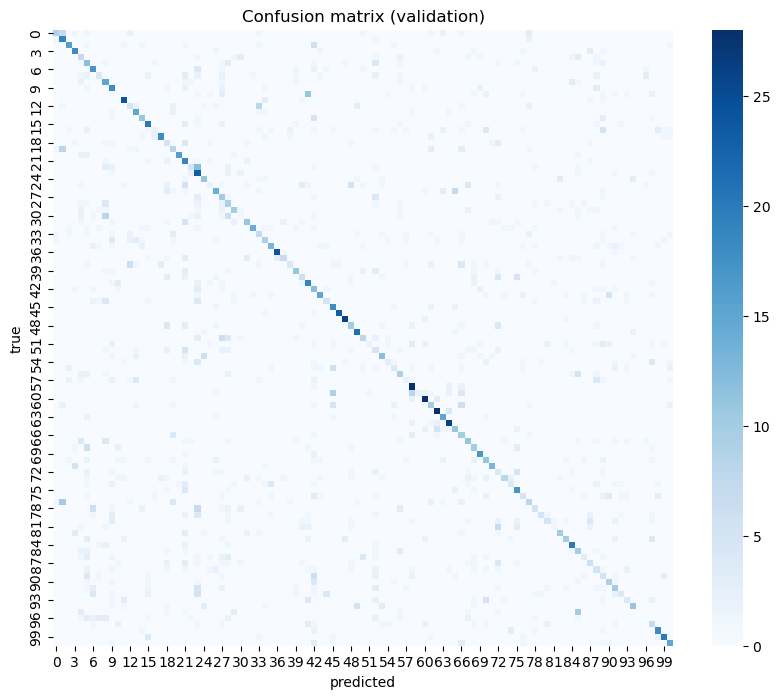


Per-class summary (top rows):
   label  precision    recall        f1  support
0      0   0.642857  0.310345  0.418605       29
1      1   0.404255  0.826087  0.542857       23
2      2   0.666667  0.551724  0.603774       29
3      3   0.600000  0.666667  0.631579       27
4      4   0.200000  0.318182  0.245614       22
5      5   0.196721  0.387097  0.260870       31
6      6   0.425000  0.566667  0.485714       30
7      7   0.307692  0.148148  0.200000       27
8      8   0.294118  0.576923  0.389610       26
9      9   0.321429  0.562500  0.409091       32

Median support used as threshold: 26

Top candidate classes (low F1, adequate support):
   label  precision    recall        f1  support
0     10   0.000000  0.000000  0.000000       27
1     16   0.333333  0.060606  0.102564       33
2     25   0.222222  0.066667  0.102564       30
3     59   1.000000  0.066667  0.125000       30
4     89   0.128205  0.178571  0.149254       28
5     88   0.166667  0.192308  0.178571       2

In [10]:
# Evaluate model on validation set, compute confusion matrix and per-class metrics
# Saves `per_class_metrics.csv` and proposes 10 candidate classes to keep.
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure we have a trained model and val_loader
try:
    model_ext
    val_loader
except NameError:
    raise RuntimeError('Model or val_loader not found in the notebook namespace. Run the training cells first.')

model_ext.eval()
all_y = []
all_pred = []
with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model_ext(kp)
        preds = logits.argmax(dim=1)
        all_y.append(labels_b.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)

labels_unique = np.unique(all_y)

# Compute per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(all_y, all_pred, labels=labels_unique, zero_division=0)
per_class = pd.DataFrame({
    'label': labels_unique,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'support': support
})
per_class = per_class.sort_values('label').reset_index(drop=True)
per_class.to_csv('per_class_metrics.csv', index=False)
print('Saved per-class metrics to per_class_metrics.csv')

# Confusion matrix (for labels present)
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Confusion matrix (validation)')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

# Strategy to propose 10 candidate classes where regularization may help:
# - We look for classes with relatively high support (so there is enough data)
# - but low F1 (model struggles)
# Rationale: classes with tiny support likely need more data, not just regularization.

min_support = max(int(np.median(per_class['support'])), 5)
candidates = per_class[per_class['support'] >= min_support].sort_values('f1').head(30)
# From these, pick 10 lowest-f1 but with decent support
selected_10 = candidates.head(10).copy().reset_index(drop=True)

print('\nPer-class summary (top rows):')
print(per_class.head(10))
print(f"\nMedian support used as threshold: {min_support}")
print('\nTop candidate classes (low F1, adequate support):')
print(selected_10)
selected_10.to_csv('selected_10_classes.csv', index=False)
print('\nSaved selected 10 classes to selected_10_classes.csv')

# Also print simple guidance for each selected class
print('\nGuidance for the selected classes:')
for _, row in selected_10.iterrows():
    lab = int(row['label'])
    print(f"- Class {lab}: support={int(row['support'])}, f1={row['f1']:.3f} -> try regularization (dropout, weight decay), augmentations, or temporal cropping.")
